# Quantum Fourier Transform (QFT)

The Quantum Fourier Transform is the quantum analogue of the discrete/fast Fourier Transform (DFT/FFT) which acts to decompose a signal to extract periodicity and phase information. QFT is a stepping stone to implement other quantum algorithms such as Shor’s algorithm and quantum phase estimation.

For $N=2^{n}$ QFT has a complexity of $O(n^{2})$, where classical FFT has a time complexity of $O(N\log N)$, making it exponentially faster. However, it is important to note the QFT's speedup is not a universal replacement for the FFT because the measurement process collapses the state, meaning you cannot extract all the same information that you can from classical FFT

In [2]:
import os
import sys
import numpy as np
from dotenv import load_dotenv
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import *
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import (SamplerV2 as Sampler)
from requests.packages import target

In [3]:
# Fetch API token and instance CRN. Stored locally in a .env file and not pushed, for obvious reasons.
load_dotenv()
API_TOKEN = os.getenv('API_TOKEN')
CRN = os.getenv('CRN')

In [4]:
# Connect to least busy backend.
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from ibmq_connect import ibmq_connect_least_busy
backend = ibmq_connect_least_busy(API_TOKEN, CRN)

qiskit_runtime_service._discover_account:WARNING:2025-11-14 01:05:30,691: Loading account with the given token. A saved account will not be used.


Name: ibm_fez
Version: 2
No. of qubits: 156



## 1. Background
### 1.1 Change of Basis

At the heart of it, QFT transforms between two basis, the computational basis and the fourier basis, a basis that represents the phase information of a state:
$$
\text{QFT}|x\rangle \xrightarrow{QFT} |\tilde{x}\rangle.
$$

Mathematically, for n qubits, this looks like:
$$
|X\rangle = \sum^{N-1}_{j=0}x_j|j\rangle \xrightarrow{\text{QFT}} \frac{1}{\sqrt{N}} \sum^{N-1}_{k=0} \big(\sum^{N-1}_{j=0}x_j \omega_N^{jk}\big)|k\rangle = |\tilde{X}\rangle, \text{ where } \omega_N^{jk} = e^{2\pi i\frac{jk}{N}} \text{ and } N = 2n.
$$
This looks like a lot of painful notation but we can look at what happens to the computational Z-basis $|0\rangle, |1\rangle$ where n=1. $|\psi\rangle = \alpha |0\rangle + \beta |1\rangle$ becomes
$$
|\psi\rangle \xrightarrow{QFT} |\tilde{\psi}\rangle = \frac{1}{\sqrt{2}}(\alpha + \beta)|0\rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)|1\rangle
$$
From this, read off the change in basis vectors as
$$
|0\rangle \xleftrightarrow{QFT} |+\rangle = \frac{1}{\sqrt(2)}(|0\rangle + |1\rangle),
$$
$$
|1\rangle \xleftrightarrow{QFT} |-\rangle = \frac{1}{\sqrt(2)}(|0\rangle - |1\rangle).
$$
This is the same as a single Hadamard gate, and we are now in the x-basis.
### 1.2 Unitary Matrix Representation
This whole process can also be represented by the unitary matrix
$$
U_{\text{QFT}} = \frac{1}{\sqrt{N}} \sum^{N-1}_{k=0} \sum^{N-1}_{j=0}\omega_N^{jk}\big|k\rangle\langle j|.
$$
Again, for the z-basis:
$$
U_{\text{QFT}} = \frac{1}{\sqrt{2}}\big(e^0\begin{bmatrix}
1 & 0\\
0 & 0
\end{bmatrix} +
e^0\begin{bmatrix}
0 & 1\\
0 & 0
\end{bmatrix} +
e^0\begin{bmatrix}
0 & 0\\
1 & 0
\end{bmatrix} +
e^{i\pi}\begin{bmatrix}
0 & 0\\
0 & 1
\end{bmatrix}
\big)
=\frac{1}{\sqrt{2}}\begin{bmatrix}
1 & 1\\
1 & -1
\end{bmatrix} = H
$$
This is the matrix representation for the Hadamard gate.
### 1.3 Intuition
This example hopefully shows what the change of basis actually looks like. Imagine plotting the integer 9: '1001'

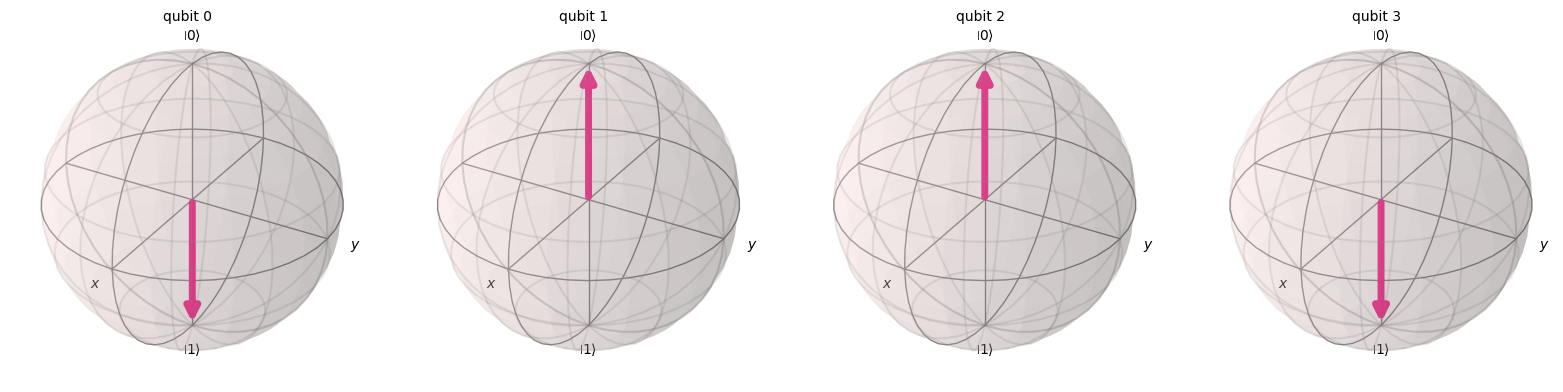

In [5]:
from qiskit.visualization import plot_bloch_multivector

n = 4
qr = QuantumRegister(n)
qc = QuantumCircuit(qr)
qc.x([0,n-1])
plot_bloch_multivector(qc)

C:\Users\willd\AppData\Local\Temp\ipykernel_8788\699840477.py:4: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(n, do_swaps=True).to_instruction()


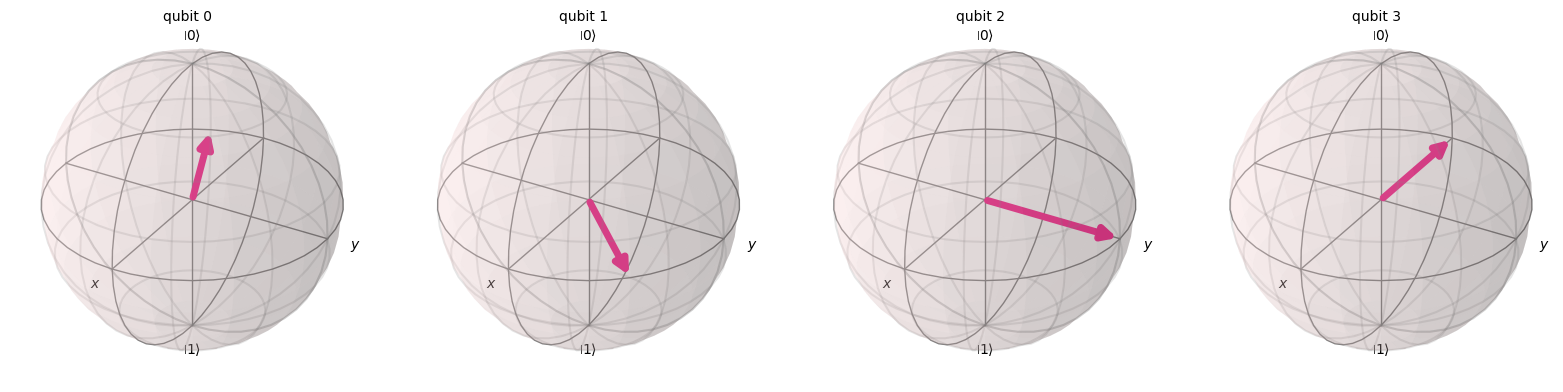

In [6]:
from qiskit.circuit.library import UnitaryGate, QFT

# apply quantum fourier transform
qft = QFT(n, do_swaps=True).to_instruction()
qc.append(qft, list(range(n)))
plot_bloch_multivector(qc)

After the QFT, 1001 is instead represented in the x-basis by four qubits with rotations around the z-axis. I'm going to do my best to explain the difference between the basis here:

For the computational z-basis, if you count up through the integers, the first bit is constantly switching between 0 and 1, the second switches every 4 numbers, the third every 8, fourth every 16 and so on.

In a similar way, starting with every qubit in $|+\rangle$, the fourier basis has the rightmost qubit do a $2\pi/2$ rotation around the z-axis every step up, the second rightmost does a $2\pi/4$ rotation, then the third rightmost does a $2\pi/8$, and fourth does a $2\pi/16$. The principle order is reversed but otherwise it acts essentially the same but in the x-basis.

So, the integer 9 can be represented by the rotations:
   - qubit 1: $2\pi \cdot 9/16 = 9\pi/8$
   - qubit 2: $2\pi \cdot 9/8 = 9\pi/4 = \pi/4$
   - qubit 3: $2\pi \cdot 9/4 = 9\pi/2 = \pi/2$
   - qubit 4: $2\pi \cdot 9/2 = 9\pi = \pi$

Hence, we get the representation shown above.

## 2. QFT Circuit
### 2.1 Forward QFT
With this intuition in mind, when changing the basis vector we need to first change it to the x-basis, which we can do with a Hadamard gate, and then rotate it around the z-axis. Imagine QFT acting on state $|x\rangle = |x_1 x_2 ... x_n\rangle$

The Hadamard gate part is simple. We have:
$$
H|x_k\rangle = \frac{1}{\sqrt{2}}\big(|0\rangle + \text{exp}(\frac{2\pi i}{2}x_k)|1\rangle\big)
$$
This is either $|+\rangle$ or $|-\rangle$.

The second part is a bit harder, as we need to rotate depending on the state of each qubit. We can do this by using a controlled rotation defined as

$$
CROT_k = \begin{bmatrix}
I & 0\\
0 & UROT_k
\end{bmatrix}
\text{ where }
UROT_k = \begin{bmatrix}
1 & 0\\
0 & exp(\frac{2\pi i}{2^k})
\end{bmatrix}
$$

where $k=2,..,n$. This acts like most controlled gates, and only rotates the target qubit if the control is $|1\rangle$. Thinking about the example of changing the basis for the integer 9, this will allow us to rotate the new basis depending on if the old basis state is in the state 0 or 1. I think a key part of $UROT_k$ is that the $2^k$ allows us to progressively decrease those rotations, as described above.

These two gates give us a process for changing the first of n qubits:
   - Hadamard qubit 1. i.e. Change to $|+\rangle$ and rotate around z-axis by $\theta = \pi$ if qubit 1.
   - Apply UROT_2 gate on qubit 1 controlled by qubit 2. Rotate around z-axis by $\theta = \frac{2\pi}{2^2} = \pi/2$ if qubit 2.
   - Apply UROT_3 gate on qubit 1 controlled by qubit 3. Rotate around z-axis by $\theta = \frac{2\pi}{2^3} = \pi/4$ if qubit 3.
   - ...
   - Apply UROT_n gate on qubit 1 controlled by qubit n. Rotate around z-axis by $\theta = \frac{2\pi}{2^n} = \pi/2^{n-1}$ if qubit n.

Thinking about the example where x = 9 = 1001. We have:
   - Hadamard qubit 1, and rotate by $\pi$ as qubit 1 is in state 1.
   - qubit 2 in state 0 so don't rotate.
   - qubit 3 in state 0 so don't rotate.
   - qubit 4 in state 1 so rotate by $\theta = \frac{2\pi}{2^4} = \pi/8$.

This gives a total rotation of $9\pi/8$, which is what we see above.

We can sequentially apply this process to the whole circuit. We have a **sub-routine** for the i-th qubit:
   - Hadamard qubit i. i.e. Change to $|+\rangle$ and rotate around z-axis by $\theta = \pi$ if qubit i.
   - Apply $UROT_2$ gate on qubit i controlled by qubit i+1. Rotate around z-axis by $\theta = \frac{2\pi}{2^2} = \pi/2$ if qubit i+1.
   - Apply $UROT_3$ gate on qubit i controlled by qubit i+2. Rotate around z-axis by $\theta = \frac{2\pi}{2^3} = \pi/4$ if qubit i+2.
   - ...
   - Apply $UROT_{n-i+1}$ gate on qubit i controlled by qubit n-i+1. Rotate around z-axis by $\theta = \frac{2\pi}{2^{n-i+1}} = \pi/2^{n-i}$ if qubit n-i+1.

At i=n, we just have a Hadamard gate. This will progressively set all the qubits into their rotations. I will implement this and test on the integer 9. I will use the controlled phase qiskit function **`cp()`** to apply the controlled phase rotations.

In [7]:
def qft_rotate(circuit: QuantumCircuit, i: int, _n: int, barriers:bool=True):
    """
    Apply the QFT subroutine to qubit i.

    Parameters
    ----------
    circuit : QuantumCircuit, required. The circuit to modify.
    i : int, required. Index of the qubit being transformed.
    _n : int, required. Total number of qubits.
    barriers : bool, optional. If True, insert visual barriers.

    Returns
    -------
    QuantumCircuit. The modified circuit.
    """
    if barriers:
        circuit.barrier()

    # Apply Hadamard to start the QFT on qubit i
    circuit.h(i)

    # Final qubit receives no controlled rotations
    if i == _n - 1:
        return circuit

    # Controlled phase rotations with decreasing powers
    for j in range(1, _n - i):
        theta = 2 * np.pi / (2 ** (j + 1))
        circuit.cp(theta, i + j, i)

    return circuit


def qft_circuit(circuit: QuantumCircuit, _n: int, barriers:bool=True):
    """
    Apply the full Quantum Fourier Transform (QFT).

    Parameters
    ----------
    circuit : QuantumCircuit, required. The circuit to modify.
    _n : int, required. Total number of qubits.
    barriers : bool, optional. If True, insert visual barriers.

    Returns
    -------
    QuantumCircuit. The modified circuit.
    """
    for i in range(_n):
        qft_rotate(circuit, i, _n, barriers)

    return circuit

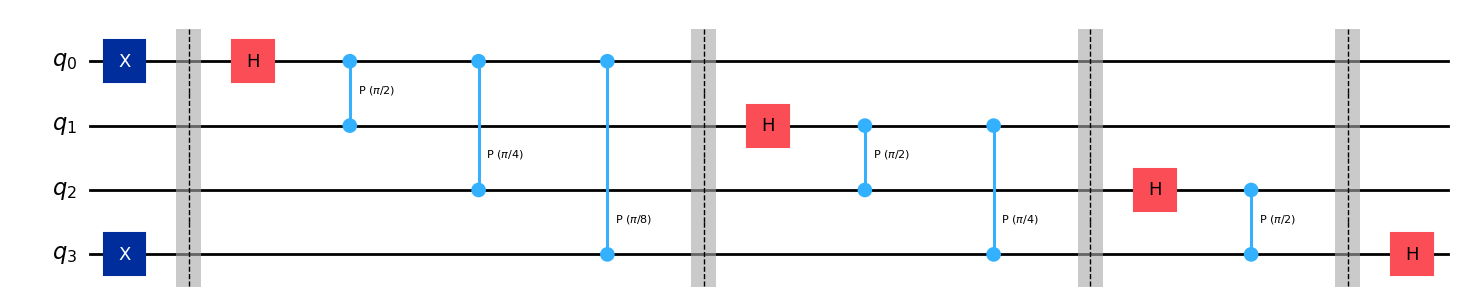

In [8]:
num_qubits = 4
qc = QuantumCircuit(num_qubits)
qc.x([0,num_qubits-1])
qc = qft_circuit(qc, num_qubits)
qc.draw('mpl', style='iqp')

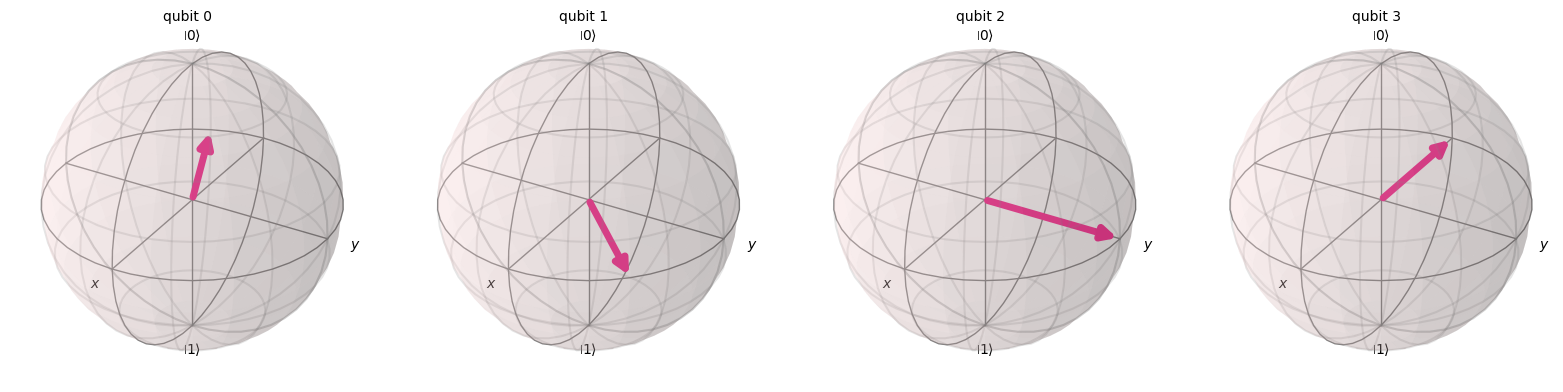

In [9]:
plot_bloch_multivector(qc)

### 2.2 Swapping Endian
When we measure in the z-basis we read the first bit to mean 0 or 1, the second to mean 0 or 2, the third to mean 0 or 4, and so on. This is little-endian notation. The bit that changes the most when counting is the first, then the second etc. Once we have applied the QFT the notation is now big-endian. The bit that changes the most is the last, then the second last etc. We see this in the example with 9, if counting up to 10, where the rightmost bit undergoes a rotation of $\pi$, the leftmost bit undergoes rotation of $\pi/8$. It can be beneficial to have functionality that allows you to swap this.

In [10]:
def swap_registers(circuit: QuantumCircuit, _n: int, barriers:bool=True):
    """
    Reverse the order of qubits to correct endian layout.

    Parameters
    ----------
    circuit : QuantumCircuit, required. The circuit to modify.
    _n : int, required. Number of qubits.
    barriers : bool, optional. If True, insert visual barriers.

    Returns
    -------
    QuantumCircuit. The circuit with swapped qubits.
    """
    if barriers:
        circuit.barrier()

    for qubit in range(_n // 2):
        circuit.swap(qubit, _n - qubit - 1)

    return circuit

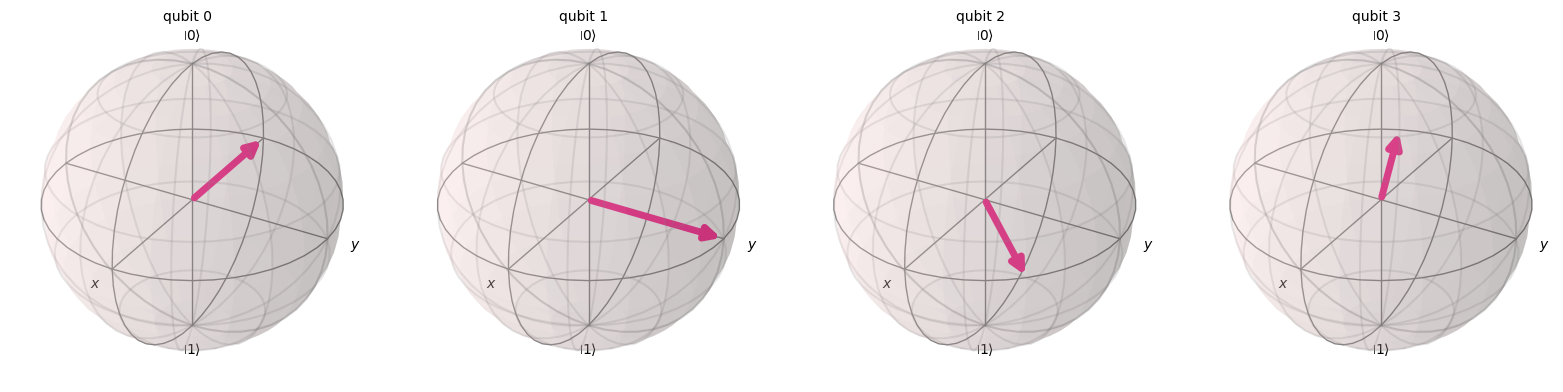

In [11]:
qc = QuantumCircuit(num_qubits)
qc.x([0,num_qubits-1])
qc = qft_circuit(qc, num_qubits)
qc = swap_registers(qc, num_qubits)
plot_bloch_multivector(qc)

### 2.3 Inverse QFT
Doing the inverse of the fourier transform is actually going to be a lot more useful than the forward transform. If we have the phase information of a state, we can use the IQFT to transform this into a sharp frequency that is readable. I am going to cheat a bit for this, and use the in-built inverse functionality.

Since QFT is unitary, we can use the fact that $U^{-1} = U^{\dagger}$, where $U^{\dagger}$ = gates reversed in time, each gate adjointed.

The adjoint to a phase rotation is a phase rotation by the same $\theta$ in reverse, and teh adjoint to a Hadamard gate is just the Hadamard gate. This makes it pretty easy to reconstruct an inverse QFT.

In [12]:
def iqft_rotate(circuit: QuantumCircuit, i: int, _n: int, barriers:bool=True):
    """
    Apply the inverse QFT subroutine to qubit i.

    Parameters
    ----------
    circuit : QuantumCircuit, required. The circuit to modify.
    i : int, required. Index of the qubit being transformed.
    _n : int, required. Total number of qubits.
    barriers : bool, optional. If True, insert visual barriers.

    Returns
    -------
    QuantumCircuit. The modified circuit.
    """
    if barriers:
        circuit.barrier()

    # Controlled-phase gates, reversed order, negative angle
    for j in reversed(range(1, _n - i)):
        theta = -2 * np.pi / (2 ** (j + 1))
        circuit.cp(theta, i + j, i)

    # Hadamard is its own inverse
    circuit.h(i)

    return circuit


def iqft_circuit(circuit: QuantumCircuit, _n: int, barriers:bool=True):
    """
    Apply the full inverse Quantum Fourier Transform (IQFT).

    Parameters
    ----------
    circuit : QuantumCircuit, required . The circuit to modify.
    _n : int, required . Number of qubits.
    barriers : bool, optional . If True, insert visual barriers.

    Returns
    -------
    QuantumCircuit
        The circuit with IQFT applied.
    """
    for i in reversed(range(_n)):
        iqft_rotate(circuit, i, _n, barriers)

    return circuit

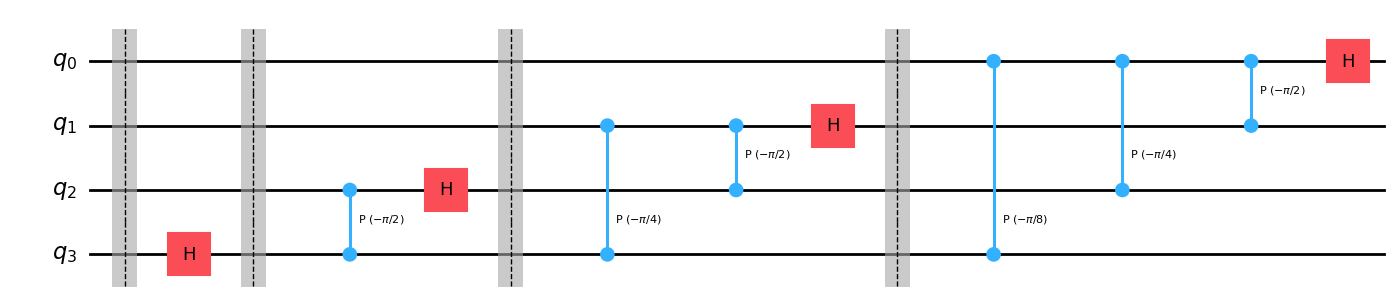

In [13]:
qc = QuantumCircuit(num_qubits)
invs_qc = iqft_circuit(qc, num_qubits)
qc.draw('mpl')

## 3. Wrapping
### 3.1 Packaging
I can put this all together into one lovely looking function. 

In [14]:
def qft(circuit: QuantumCircuit, _n: int, inverse:bool=False, swap_endian:bool=False, barriers:bool=False):
    """
    Apply the Quantum Fourier Transform or its inverse.

    Parameters
    ----------
    circuit : QuantumCircuit, required. The circuit to modify.
    _n : int, required. Number of qubits.
    inverse : bool, optional. If True, apply the inverse QFT instead of the forward QFT.
    swap_endian : bool, optional. If True, swap qubits to correct endian order.
    barriers : bool, optional. If True, insert visual barriers.

    Returns
    -------
    QuantumCircuit
        The modified circuit.
    """
    if inverse:
        circuit = iqft_circuit(circuit, _n, barriers)
    else:
        circuit = qft_circuit(circuit, _n, barriers)

    if swap_endian:
        circuit = swap_registers(circuit, _n, barriers)

    return circuit

It is kind of hard to test if this is working on the forward pass, but on the inverse it should be easy. We can set the correct phases for integer 9, then run the inverse pass, and see what we get.

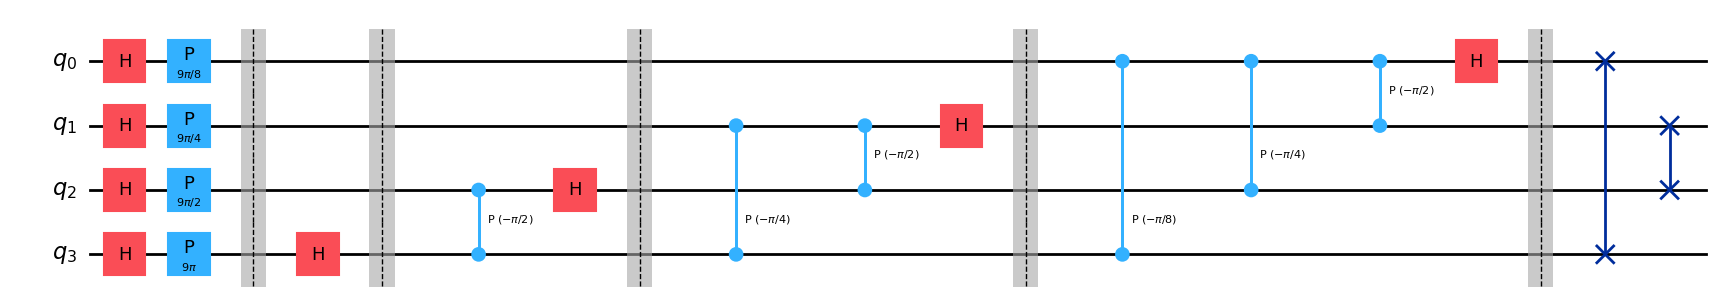

In [22]:
qc = QuantumCircuit(num_qubits)
target_int = 9

# set phases of qubits in x-basis
qc.h(list(range(num_qubits)))
qc.p(target_int*np.pi/8,0)
qc.p(target_int*np.pi/4,1)
qc.p(target_int*np.pi/2,2)
qc.p(target_int*np.pi,3)

# inverse qft
qc = qft(qc, num_qubits, inverse = True, swap_endian = True, barriers=True)
plot_bloch_multivector(qc)

qc.draw('mpl')

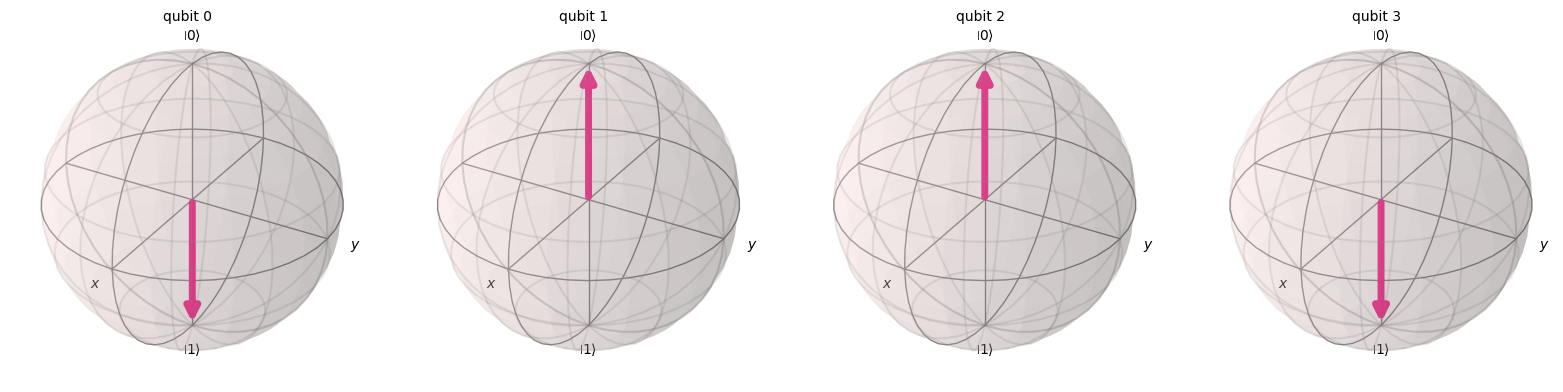

In [23]:
plot_bloch_multivector(qc)

### 3.2 Testing on Backend
It's probably only worth testing the inverse pass on a backend. I'll pass in this integer 9 circuit, and see what it spits out.

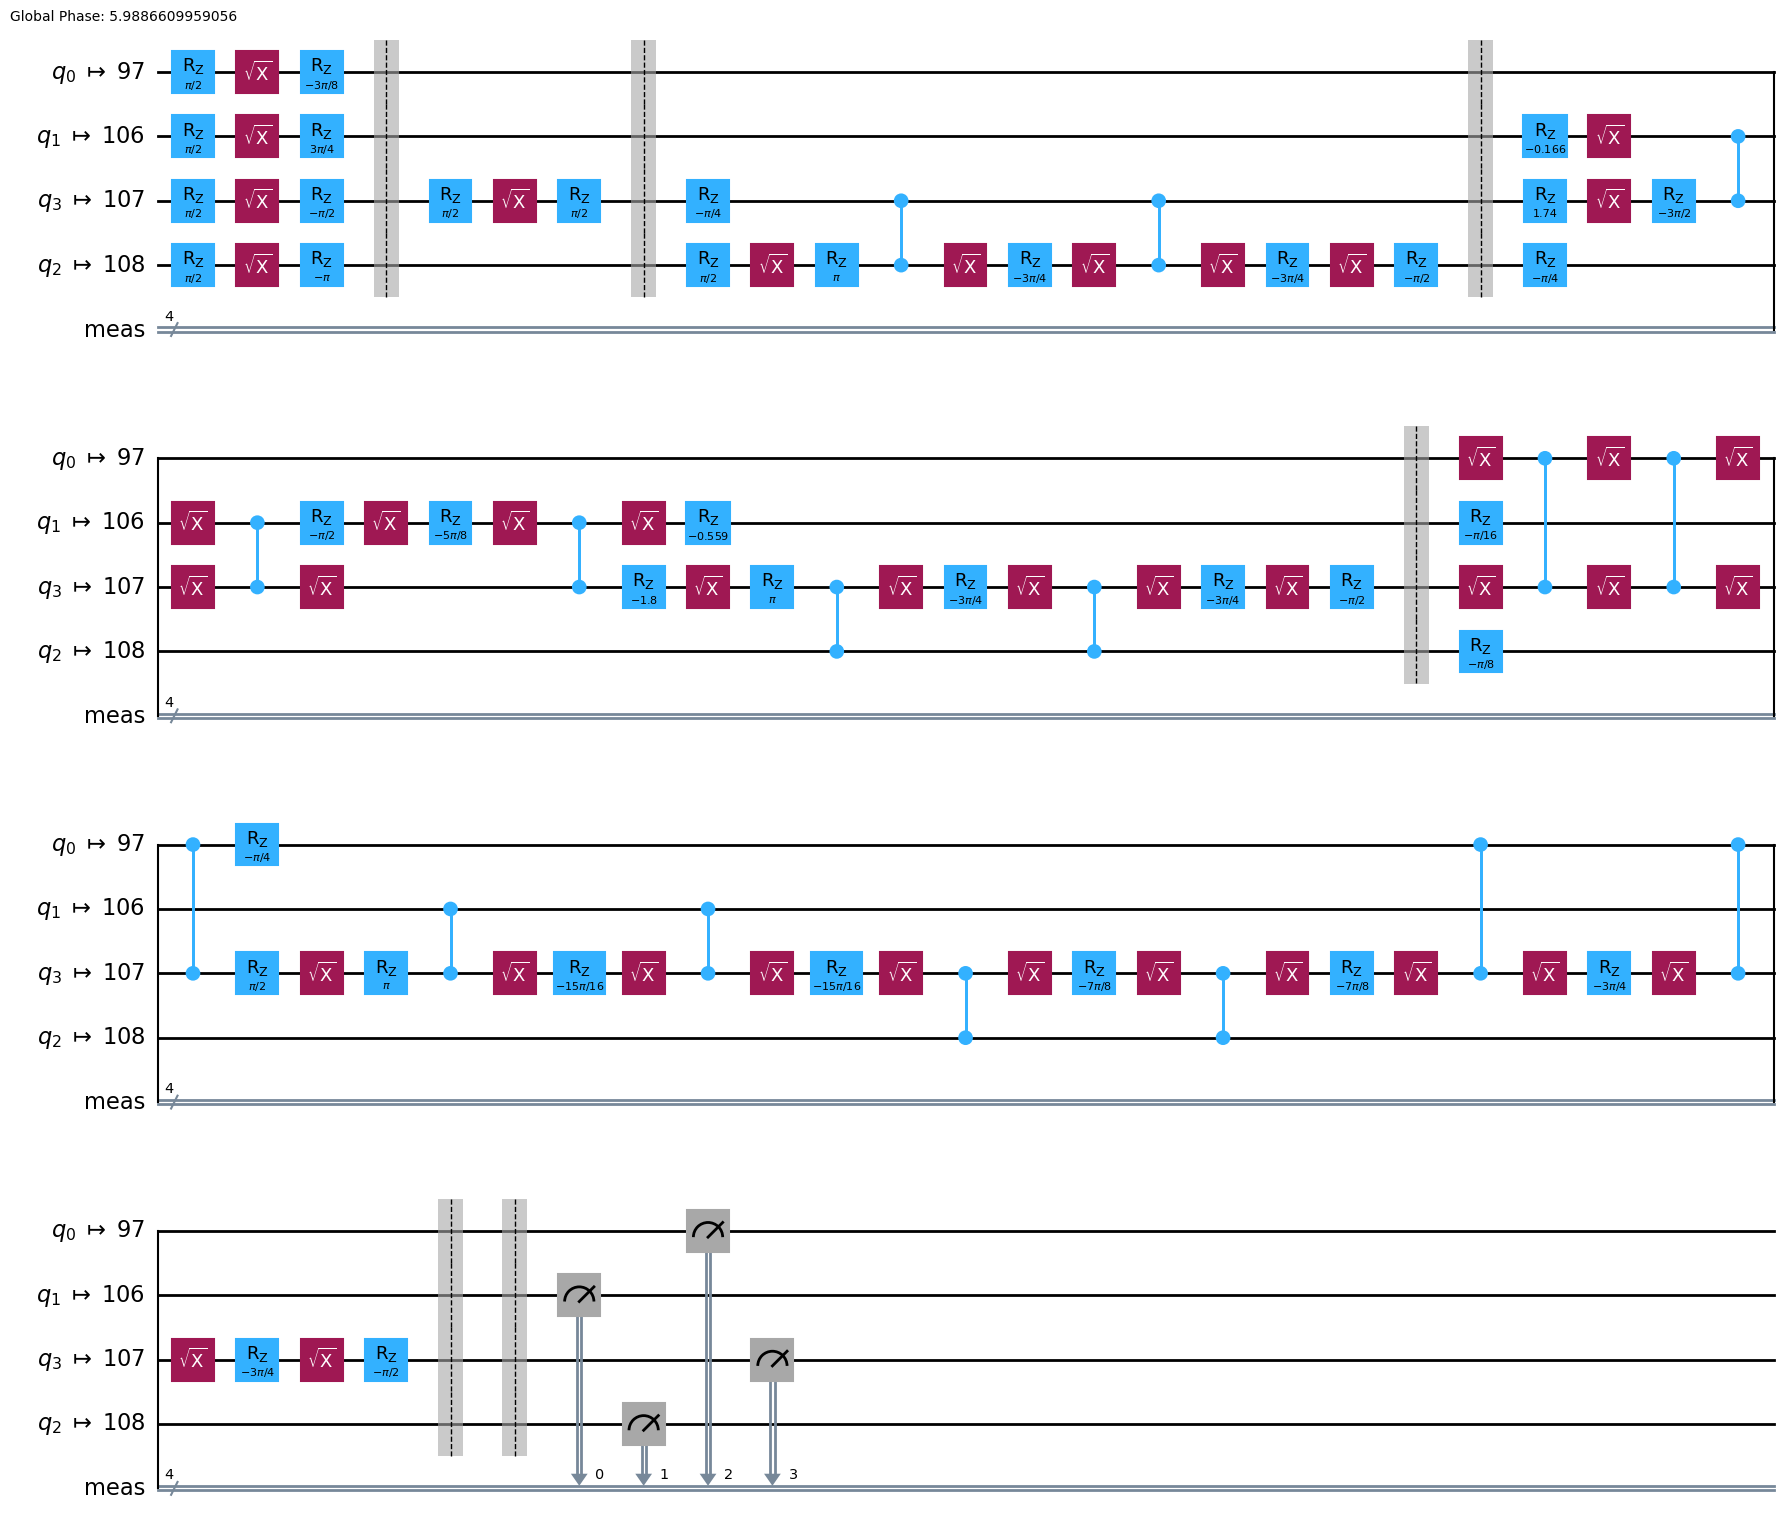

In [24]:
qc.measure_all()

# Transpile
backend_target = backend.target
pm = generate_preset_pass_manager(target=backend_target, optimization_level=3)
qc_isa = pm.run(qc)
qc_isa.draw('mpl')

In [25]:
# Run Algorithm on Hardware
sampler = Sampler(mode=backend)
pubs = [qc_isa]
job = sampler.run(pubs, shots=1024)
res = job.result()

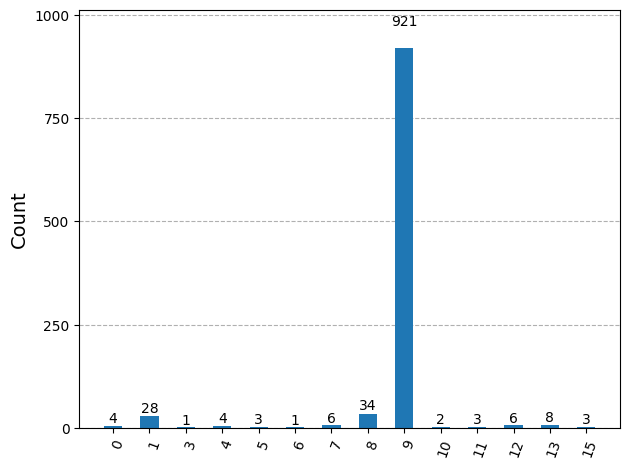

In [26]:
# get data in readable format
bitstrings = res[0].data.meas.get_counts()
counts = {int(bitstring, 2): count for bitstring, count in bitstrings.items()}
plot_histogram(counts)

Accurate enough on real backend for any of my purposes. I have put all of the above functions into one Script **`qft.py`**